In [1]:
import torch
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import copy
from PIL import Image
from scipy.io import loadmat

BATCH_SIZE = 1

In [2]:
VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')


In [3]:
def filter_small_boxes(boxes, min_size):
    """Filters out small boxes."""
    w = boxes[:, 2] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 1]
    mask = (w >= min_size) & (h >= min_size)
    return mask

In [4]:
def totensor(img):
    t = transforms.ToTensor()
    return t(img)

def hflip_box(boxes, w):
    for box in boxes:
        box[0], box[2] = w - box[2], w - box[0]

def hflip_img(img):
    """
    img : PIL Image
    """
#     fliper = transforms.RandomHorizontalFlip(1)
#     cflip(src, flipCode[, dst])
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def x2ychange_box(boxes):
    for box in boxes:
        box[0], box[1] = box[1], box[0]
        box[2], box[3] = box[3], box[2]

def resize_box(boxes, ratio):
    for box in boxes:
        box[0] = int(ratio * box[0])
        box[1] = int(ratio * box[1])
        box[2] = int(ratio * box[2])
        box[3] = int(ratio * box[3])
    
def resize_img_maxlength(img, maxlength):
    """
    img : PIL Image
    maxlength : change the image max side length to 
    """
    w, h = img.size
    if (w > h):
        resizer = transforms.Resize((int(maxlength*h/w), maxlength))
        ratio = maxlength/w
    else: # h >= w
        resizer = transforms.Resize((maxlength, int(maxlength*w/h)))
        ratio = maxlength/h
    img = resizer(img)
    return img, ratio

def remove_repetition(boxes):
    """
    remove repetited boxes
    :param boxes: [N, 4]
    :return: keep:
    """
    _, x1_keep = np.unique(boxes[:, 0], return_index=True)
    _, x2_keep = np.unique(boxes[:, 2], return_index=True)
    _, y1_keep = np.unique(boxes[:, 1], return_index=True)
    _, y2_keep = np.unique(boxes[:, 3], return_index=True)
 
    x_keep = np.union1d(x1_keep, x2_keep)
    y_keep = np.union1d(y1_keep, y2_keep)
    keep = np.union1d(x_keep, y_keep)
    return keep

In [5]:
class VOCAnnotationAnalyzer():
    """
    deal with annotation data (dict)
    
    Arguments:
        cls_to_idx (dict, optional): dictionary lookup of classnames -> indexes
            (default: alphabetic indexing of VOC's 20 classes)
        keep_difficult (bool, optional): keep difficult instances or not
            (default: False)
        height (int): height
        width (int): width
    """
    def __init__(self, cls_to_idx=None, keep_difficult=False):
        self.cls_to_idx = cls_to_idx or dict(zip(VOC_CLASSES, range(len(VOC_CLASSES))))
        self.keep_difficult = keep_difficult
        
    def __call__(self, annotation: dict):
        w = int(annotation['size']['width'])
        h = int(annotation['size']['height'])
        # if img only contains one gt that annotation['object'] is just a dict, not a list
        objects = [annotation['object']] if type(annotation['object']) != list else annotation['object']
        res = [] # [xmin, ymin, xmax, ymax, label]
        for box in objects:
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            difficult = int(box['difficult'])
            if not self.keep_difficult and difficult:
                continue
            name = box['name']
            bnd = []
            for pt in pts:
                bnd.append(int(box['bndbox'][pt]))
            bnd.append(self.cls_to_idx[name])
            res.append(bnd)
            
        return res

In [33]:
class VOCDectectionDataset(data.Dataset):
    def __init__(self, root, year, image_set,
                 transform=None, 
                 target_transform=VOCAnnotationAnalyzer(),
                 dataset_name='VOC07_12',
                 region_propose='selective_search',
                 debug=False):
        super(VOCDectectionDataset, self).__init__()
        self.datas = datasets.VOCDetection(root, str(year), image_set, download=False)
        self.image_set = image_set
        self.transform = transform
        self.name = dataset_name
        self.target_transform = target_transform # use for annotation
        self.longer_sides = [480, 576, 688, 864, 1200]
        self.longer_sides_val = [480, 576]
        self.debug = debug
        if region_propose not in ['selective_search', 'edge_box']:
            raise NotImplementedError(f'{region_propose} not Supported')

        self.region_propose = region_propose
        self.box_mat = self.get_mat(year, image_set, region_propose)
            
            
    def get_box_from_mat(self, index):
        return self.box_mat['boxes'][0][index].tolist()

    def get_boxScore_from_mat(self, index):
        score = None
        if self.region_propose == 'edge_box':
            score = self.box_mat['boxScores'][0][index].tolist()
        return score
    
    def get_mat(self, year, image_set, region_propose):
        """
        load the box generated
        """
        boxes = None
        boxes_score = None
        
        if str(year) == '2007' and image_set == 'trainval' and region_propose == 'selective_search':
            mat = loadmat("../region/SelectiveSearchVOC2007trainval.mat")
        elif str(year) == '2007' and image_set == 'test' and region_propose == 'selective_search':
            mat = loadmat("../region/SelectiveSearchVOC2007test.mat")
        if str(year) == '2007' and image_set == 'trainval' and region_propose == 'edge_box':
            mat = loadmat("../region/EdgeBoxesVOC2007trainval.mat")
        elif str(year) == '2007' and image_set == 'test' and region_propose == 'edge_box':
            mat = loadmat("../region/EdgeBoxesVOC2007test.mat")
        return mat
            
    def __getitem__(self, index):
        img, gt = self.datas[index]
        region = self.get_box_from_mat(index)
        region_score = self.get_boxScore_from_mat(index)
        if self.target_transform:
            gt = self.target_transform(gt["annotation"])
        w, h = img.size
        
        region = np.array(region).astype(np.float32)
        region_filter = filter_small_boxes(region, 20)
        region = region[region_filter]
        
        unique_filter = remove_repetition(region)
        region = region[unique_filter]
        
        x2ychange_box(region)

        if region_score is not None:
            region_score = np.array(region_score).astype(np.float32)
            region_score = region_score[region_filter]
            region_score = region_score[unique_filter]
        gt = np.array(gt).astype(np.float32)

        # ----------------------------------------------------------------------------------
        if self.debug == True:
            return img, gt, region
        
        
        elif self.image_set == "trainval":
            target = [0 for _ in range(len(VOC_CLASSES))]
            gt_target = gt[:, -1]
            for t in gt_target:
                target[int(t)] = 1.0
            gt_box = gt[:, :4]
            gt_target = np.array(target).astype(np.float32)
            
            if self.transform is None:
                # follow by paper: randomly horiztontal flip and randomly resize
                if np.random.random() > 0.5: # then flip
#                     print("Flip!")
                    img = hflip_img(img)
                    hflip_box(region, w)
                    hflip_box(gt_box, w)
                # then resize
                max_side = self.longer_sides_small[np.random.randint(2)]
#                 print(f"resize_to_{max_side}")
                img, ratio = resize_img_maxlength(img, max_side)
                resize_box(region, ratio)
                resize_box(gt_box, ratio)
            else:
                raise NotImplementedError("This dataset can only be compatible with the paper's implementation")

#             img = totensor(img)


            if region_score is None:
                return img, gt_box, gt_target, region, np.array([0])
            else:
                return img, gt_box, gt_target, region, region_score
        # ----------------------------------------------------------------------------------

        elif self.image_set == "test":
            ten_images = []
            ten_regions = []
            if self.transform is not None:
                raise NotImplementedError("This dataset can only be compatible with the paper's implementation")
            else:
                # first change box's cor
                # follow by paper: get 10 images for hflip and resize2 5sizes
                for flip in [0.0, 1.0]:
                    for max_side in self.longer_sides_small:
                        new_img = img.copy()
                        new_region = copy.deepcopy(region)
                        if flip == 1.0:
                            new_img = hflip_img(new_img)
                            hflip_box(new_region, w)
                        new_img, ratio = resize_img_maxlength(new_img, max_side)
                        resize_box(new_region, ratio)
                        

                        ten_images.append(totensor(new_img))
#                         ten_images.append(new_img)
                        ten_regions.append(new_region)

            if region_score is None:
                return ten_images, gt, ten_regions, region, np.array([0])
            else:
                return ten_images, gt, ten_regions, region, region_score
            
        else:
            raise ValueError(f"image_set can only be 'test' or 'trainval'")
        
    def __len__(self):
        return len(self.datas)

In [34]:
vd = VOCDectectionDataset("~/data/", 2007, 'trainval', debug=True)

In [37]:
boxes = vd[0][2]

In [38]:
boxes.shape

(879, 4)

In [28]:
boxes[idx].shape

(730, 4)

In [27]:
idx = remove_repetition(boxes)

In [13]:
def remove_repetition(boxes):
    """
    remove repetited boxes
    :param boxes: [N, 4]
    :return: keep:
    """
    _, x1_keep = np.unique(boxes[:, 0], return_index=True)
    _, x2_keep = np.unique(boxes[:, 2], return_index=True)
    _, y1_keep = np.unique(boxes[:, 1], return_index=True)
    _, y2_keep = np.unique(boxes[:, 3], return_index=True)
 
    x_keep = np.union1d(x1_keep, x2_keep)
    y_keep = np.union1d(y1_keep, y2_keep)
    keep = np.union1d(x_keep, y_keep)
    return keep

In [29]:
_, x1_keep = np.unique(boxes[:, 0], return_index=True)
_, x2_keep = np.unique(boxes[:, 2], return_index=True)
_, y1_keep = np.unique(boxes[:, 1], return_index=True)
_, y2_keep = np.unique(boxes[:, 3], return_index=True)

In [30]:
x1_keep

array([   0,  295,  365,  353,  392,  384, 1092,  148,  273,   14,   16,
        367,  225,   19,  360,   23,   24,  431,  498,  461,  462,  499,
        448,  502,  519,  632,  449,  605,  595,  633,  520,  728,  742,
        750,  590,  450,  591,  522,  503,  451,  586,  751, 1345, 1342,
        207,   27,   28,   36, 1061,  394, 1004,   37,  311,  286,   46,
        874,   50,  735,   63,  314,   64, 1089,  111,  113, 1066,  289,
        396,   67,  165,  117,  476,  135,  303,  956,  114,  123,  108,
        775,  598, 1171,  136,  736, 1140,  137, 1143, 1282, 1040,  334,
        155,  129,  336, 1168,  341, 1208, 1172, 1212,  975,  130,  610,
        876,  149,  131,  166,  611,  653,  565,  600,  756,  132,   70,
         74,   76,  187,  719,  487,  601,  614,  700,  342,  619, 1213,
       1053,   82,  589,  173,  620,  988, 1131, 1027, 1214, 1215,  810,
        811,   87,  308,  146, 1245,  489,   88,  602,  139,   92,   93,
         94,   97,  234,  350, 1222,  566,  567,  2

In [32]:
x2_keep

array([ 251,  241,  285,  240,  265,  385,  353, 1119,  386, 1081,  404,
        836,  703,  581,  250,  445,  656,  434,  278,  366,  229,  663,
        509,  634,  225,  584,  796,  273,  662,  594,  701,  481,  482,
        483,  293,  522,  475, 1099,  441,  223,  438,  224,  274,  367,
        359, 1345,  230,  275,    0,  242,  266,    4, 1107,   10, 1062,
        399,    5,    6, 1007, 1089,  268,   24,  983,   37,  815,  985,
         16,  120,  123,    7, 1074, 1075,  417,   19,  525,  775,  866,
        356,  137,  776,  393,  977,   39,  122,   25,  112,   57,  418,
       1331,  402,  400,  965,  743,  408,  999, 1024,  872,   47, 1187,
        992,  804, 1249, 1317,  729, 1069, 1172, 1315, 1333,  182,  786,
        756,  980,  403, 1303,   64,   74,   50,  125,  719, 1034, 1064,
        726,  953,  966,  697,  181,   52,  173,   38,   28,  184,   41,
        332,   65,   67,  322,   84,  135,  117,  527,  348,  642,  291,
         88,  643,  821, 1030,  158, 1253,  865,  8

In [31]:
np.union1d(x1_keep, x2_keep)

array([   0,    1,    2,    4,    5,    6,    7,   10,   12,   14,   16,
         19,   20,   23,   24,   25,   27,   28,   29,   36,   37,   38,
         39,   41,   43,   46,   47,   48,   50,   52,   57,   59,   63,
         64,   65,   67,   70,   74,   76,   82,   84,   87,   88,   92,
         93,   94,   97,   98,   99,  101,  102,  103,  106,  108,  111,
        112,  113,  114,  117,  120,  122,  123,  125,  129,  130,  131,
        132,  135,  136,  137,  139,  142,  143,  146,  148,  149,  152,
        153,  155,  158,  162,  164,  165,  166,  173,  174,  175,  176,
        181,  182,  184,  187,  190,  191,  192,  194,  196,  197,  199,
        200,  201,  206,  207,  208,  209,  215,  221,  223,  224,  225,
        226,  229,  230,  234,  236,  237,  238,  240,  241,  242,  245,
        247,  248,  249,  250,  251,  257,  265,  266,  268,  269,  271,
        272,  273,  274,  275,  277,  278,  285,  286,  289,  291,  293,
        295,  296,  298,  301,  303,  308,  311,  3

In [289]:
"""
train debug
"""
;
# pic, gt_box, gt_target, region, _ = vd[idx]
# draw_box(pic, region[:10])

''

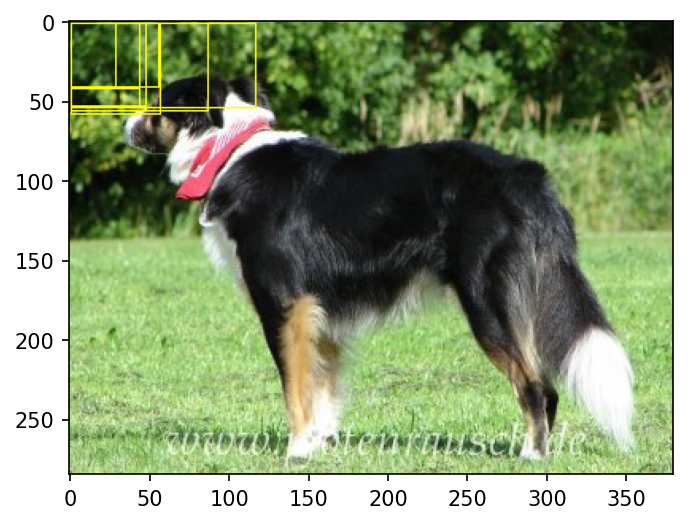

In [298]:
"""
test debug
"""

pics, gts, regions, ori_region, _ = vd[idx]
draw_box(pics[0], regions[0][:10])

In [28]:
vd = VOCDectectionDataset("~/data/", 2007, 'trainval')

In [30]:
vd[0][1]

array([[263., 211., 324., 339.],
       [165., 264., 253., 372.],
       [241., 194., 295., 299.]], dtype=float32)

In [32]:
vd[0][3]

array([[  1.,   1., 160., 418.],
       [  1.,   1., 162., 421.],
       [  1.,   1.,  84., 423.],
       ...,
       [317., 609., 359., 648.],
       [642., 611., 758., 648.],
       [482., 613., 599., 648.]], dtype=float32)

In [ ]:
mat = loadmat("../region/SelectiveSearchVOC2007trainval.mat")

In [11]:
mat

(tensor([[[0.6353, 0.6353, 0.6392,  ..., 0.0471, 0.0431, 0.0431],
          [0.6353, 0.6353, 0.6392,  ..., 0.0431, 0.0392, 0.0392],
          [0.6314, 0.6314, 0.6353,  ..., 0.0353, 0.0314, 0.0275],
          ...,
          [0.2706, 0.2706, 0.2706,  ..., 0.1765, 0.1725, 0.1686],
          [0.2706, 0.2706, 0.2667,  ..., 0.2118, 0.1922, 0.1882],
          [0.2706, 0.2706, 0.2667,  ..., 0.2196, 0.2000, 0.1922]],
 
         [[0.7255, 0.7255, 0.7294,  ..., 0.0431, 0.0392, 0.0353],
          [0.7255, 0.7255, 0.7294,  ..., 0.0392, 0.0353, 0.0314],
          [0.7333, 0.7333, 0.7333,  ..., 0.0314, 0.0275, 0.0235],
          ...,
          [0.3294, 0.3294, 0.3294,  ..., 0.0471, 0.0471, 0.0471],
          [0.3294, 0.3294, 0.3255,  ..., 0.0667, 0.0667, 0.0627],
          [0.3294, 0.3294, 0.3255,  ..., 0.0745, 0.0706, 0.0667]],
 
         [[0.7490, 0.7490, 0.7529,  ..., 0.0471, 0.0392, 0.0392],
          [0.7529, 0.7529, 0.7529,  ..., 0.0431, 0.0392, 0.0392],
          [0.7569, 0.7569, 0.7608,  ...,

In [25]:
d = datasets.VOCDetection("~/data/", "2007", "trainval", download=False)

In [30]:
d[-1]

(<PIL.Image.Image image mode=RGB size=500x374 at 0x7F0A645049D0>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '009961.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '334575803'},
   'owner': {'flickrid': 'dictioncanary', 'name': 'Lucy'},
   'size': {'width': '500', 'height': '374', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'dog',
     'pose': 'Unspecified',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '69', 'ymin': '4', 'xmax': '392', 'ymax': '345'}}]}})